In [1]:
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

In [3]:
import geopandas
from PIL import Image
import math
from tqdm import tqdm

tqdm.pandas()

In [4]:
cases = pd.read_csv("../data/external/uk_cities_covid19_cases.csv", index_col=0)

In [5]:
UK_COORDINATES = {"x_limits": [37, 41], "y_limits": [6, 9]}
Z = 6

In [6]:
pop_density = np.array(
    Image.open(
        "../data/processed/GPW_Population_Density_2020/GPW_Population_Density_2020_Z_6_2020-01-01.png"
    )
)

impervious_land = np.array(
    Image.open(
        "../data/processed/Landsat_Global_Man-made_Impervious_Surface/Landsat_Global_Man-made_Impervious_Surface_Z_6_2010-06-01.png"
    )
)

settlement_area = np.array(
    Image.open(
        "../data/processed/Landsat_Human_Built-up_And_Settlement_Extent/Landsat_Human_Built-up_And_Settlement_Extent_Z_6_2010-06-01.png"
    )
)

pop_density = np.average(pop_density[:, :, :3], axis=2)
impervious_land = np.average(impervious_land[:, :, :3], axis=2)
settlement_area = np.average(settlement_area[:, :, :3], axis=2)

In [7]:
IMAGE_SHAPE = pop_density.shape

In [8]:
def gibs_lat_lon_to_tiles(lat: float, lon: float, zoom: int):
    x = math.floor(((180 + lon) * (2 ** zoom)) / 288)
    y = math.floor(((90 - lat) * (2 ** zoom)) / 288)
    return x, y

In [9]:
def gibs_tiles_to_lat_lon(x: int, y: int, zoom: int):
    lat = 90 - (y * 288) / (2 ** zoom)
    lon = (x * 288) / (2 ** zoom) - 180
    return lat, lon

In [10]:
nw_coords = gibs_tiles_to_lat_lon(
    UK_COORDINATES["x_limits"][0], UK_COORDINATES["y_limits"][0], zoom=Z
)
se_coords = gibs_tiles_to_lat_lon(
    UK_COORDINATES["x_limits"][1], UK_COORDINATES["y_limits"][1], zoom=Z
)

In [11]:
px_to_lat = interp1d([0, IMAGE_SHAPE[0]], [nw_coords[0], se_coords[0]])
px_to_lon = interp1d([0, IMAGE_SHAPE[1]], [nw_coords[1], se_coords[1]])
lat_to_px = interp1d([nw_coords[0], se_coords[0]], [0, IMAGE_SHAPE[0]])
lon_to_px = interp1d([nw_coords[1], se_coords[1]], [0, IMAGE_SHAPE[1]])

In [12]:
def get_val_from_satellite_img(
    lat: float, lon: float, satellite_data: np.ndarray
) -> int:
    y = int(lat_to_px(lat))
    x = int(lon_to_px(lon))
    return satellite_data[y, x]

In [13]:
cases["pop_density"] = cases[["lat", "lon"]].apply(
    lambda x: get_val_from_satellite_img(x["lat"], x["lon"], pop_density), axis=1
)

cases["settlement_area"] = cases[["lat", "lon"]].apply(
    lambda x: get_val_from_satellite_img(x["lat"], x["lon"], settlement_area), axis=1
)

cases["impervious_land"] = cases[["lat", "lon"]].apply(
    lambda x: get_val_from_satellite_img(x["lat"], x["lon"], impervious_land), axis=1
)

In [14]:
cases.head()

,Region,lat,lon,growth_rate,inflection_point,Cases,Traffic,pop_density,settlement_area,impervious_land
0,Barking and Dagenham,51.54530,0.13410,0.084263,35.023586,13.0,160210853,75.666667,104.666667,128.666667
1,Barnet,51.61580,-0.20990,0.137784,14.503009,-839.0,41995122,75.666667,225.000000,225.000000
2,Barnsley,53.53600,-1.53210,0.070149,53.410039,22.0,107427507,133.333333,104.666667,205.333333
3,Bath and North East Somerset,51.35393,-2.46979,0.136591,14.002283,-172.0,1107289,163.333333,225.000000,225.000000
4,Bedford,52.18910,-0.47700,0.093280,23.145034,-312.0,74054852,160.000000,225.000000,225.000000


In [15]:
cases_features = cases[
    [
        "growth_rate",
        "inflection_point",
        "Cases",
        "Traffic",
        "pop_density",
        "settlement_area",
        "impervious_land",
    ]
]

In [21]:
cases_features = cases_features.replace({"None": None})
cases_features = cases_features.fillna(0)
cases_features["Traffic"] = cases_features.Traffic.astype(float)

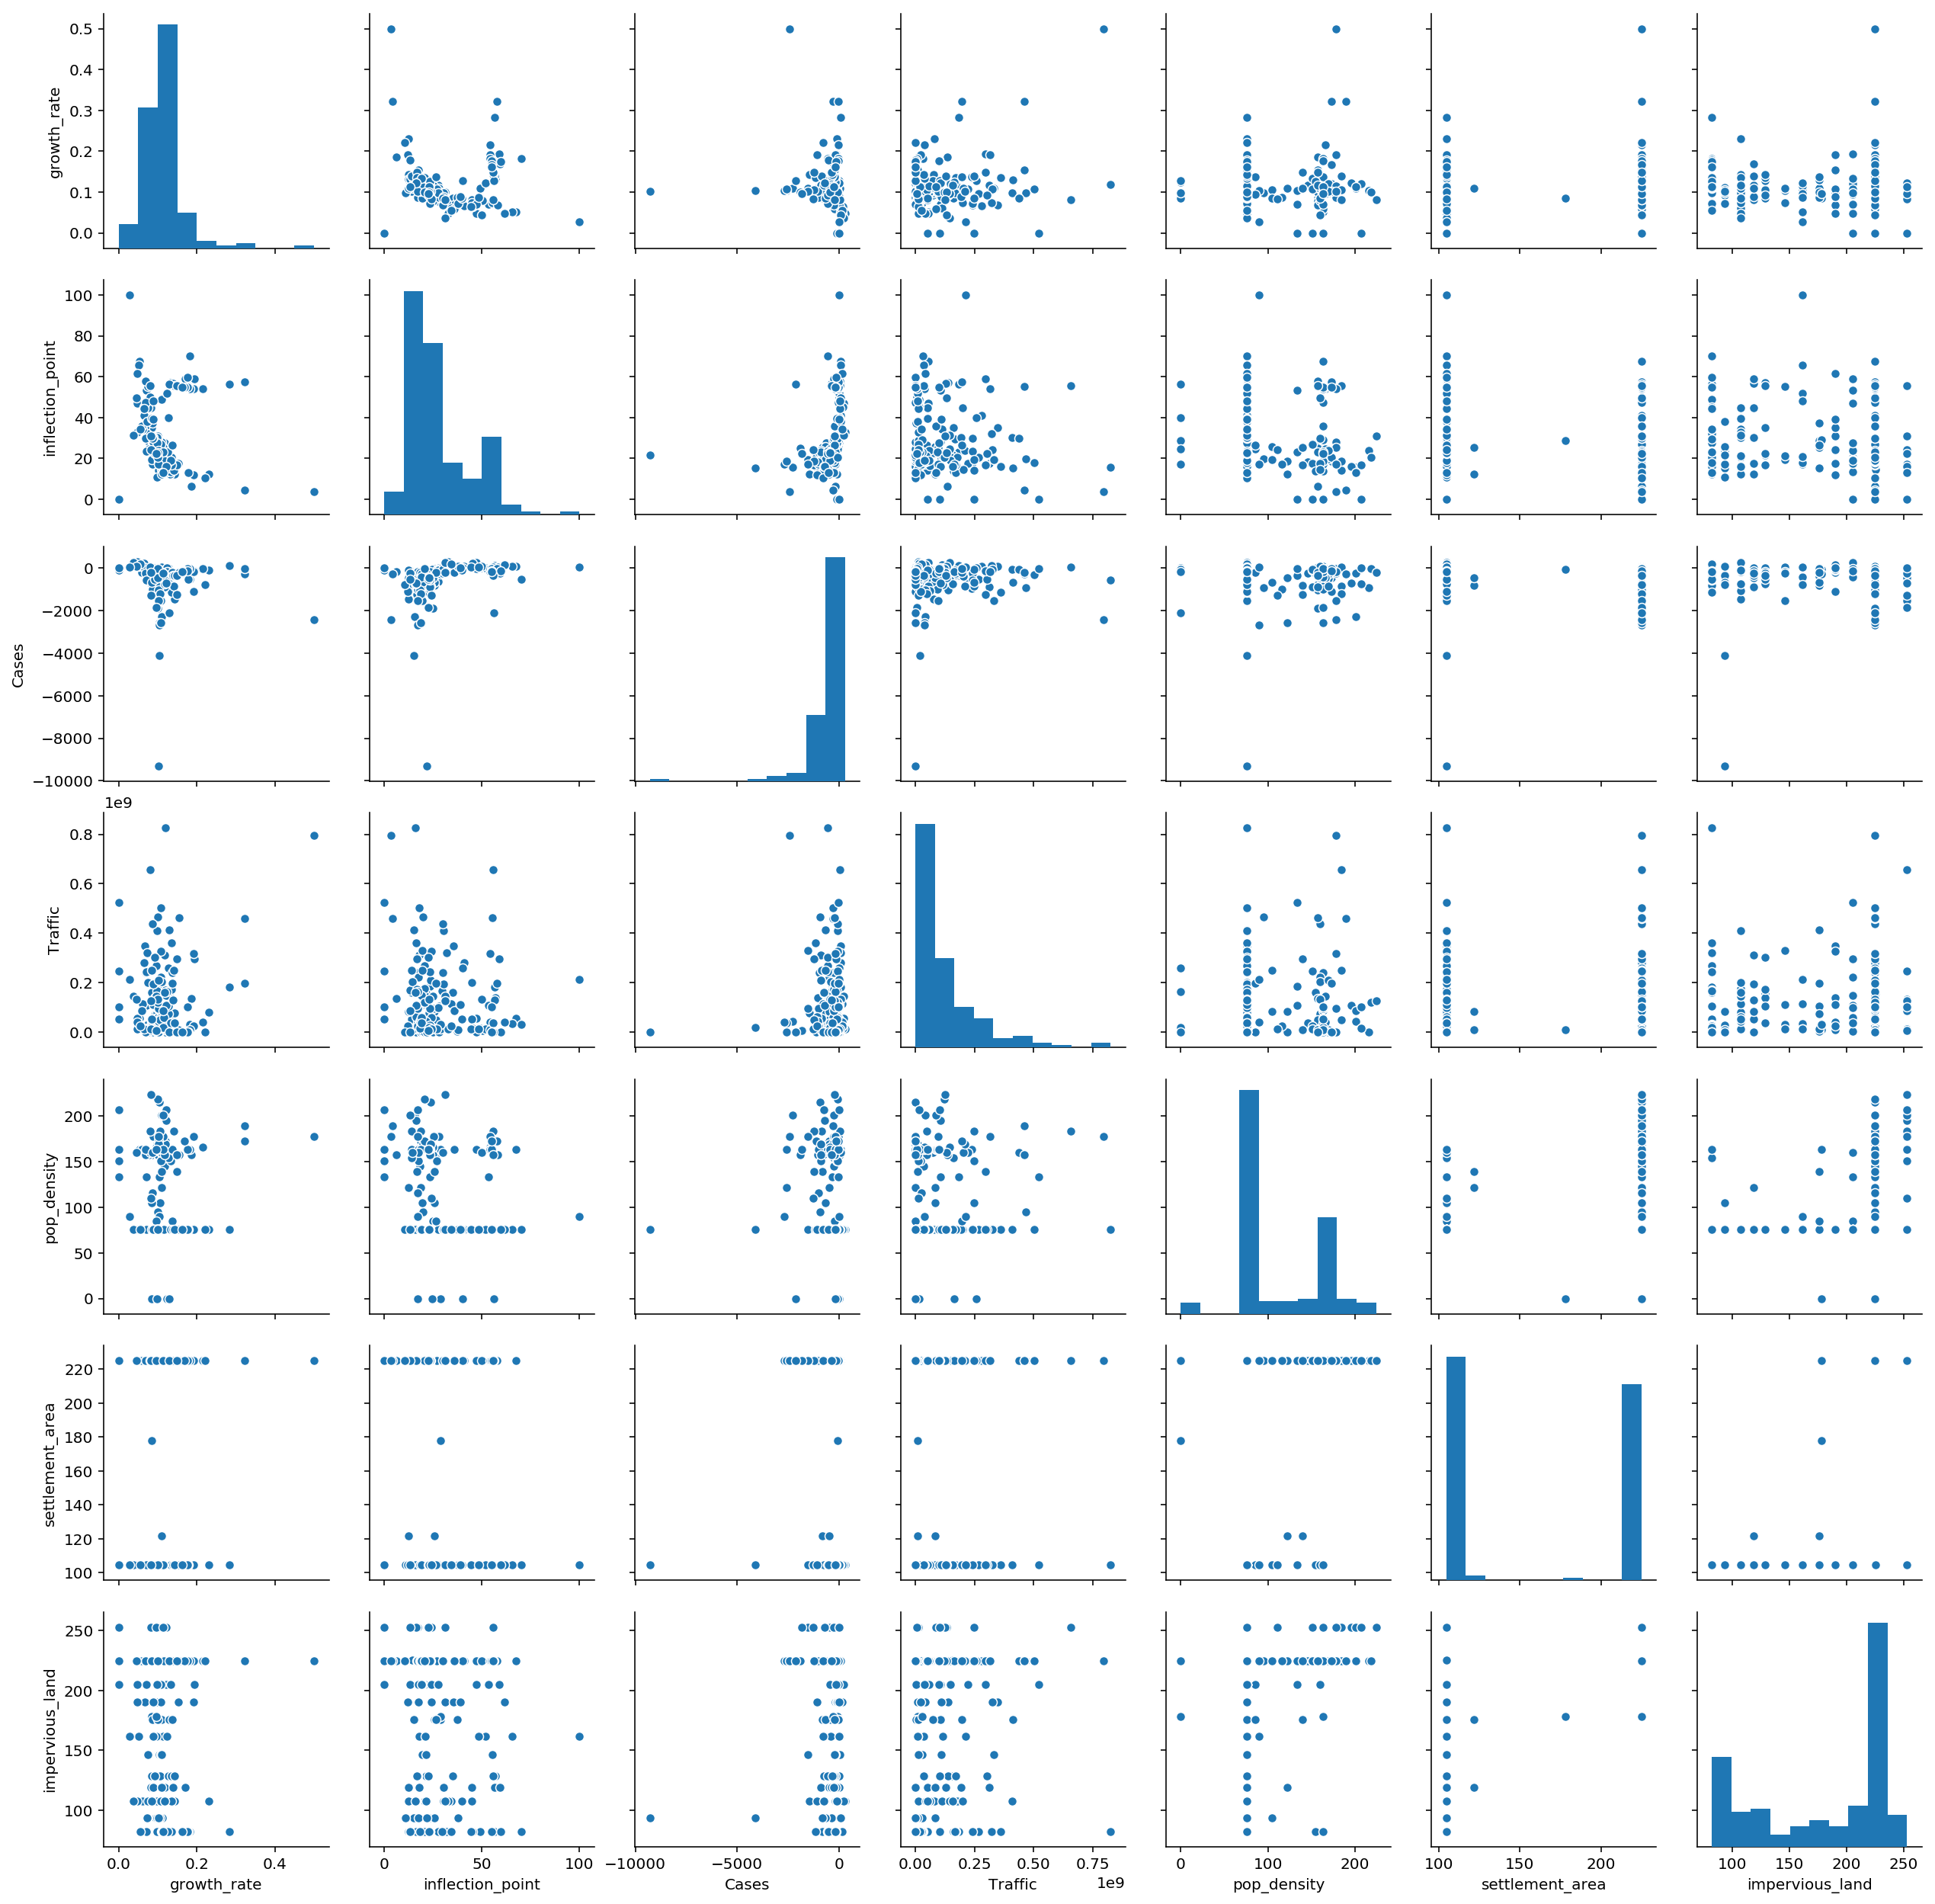

In [23]:
sns.pairplot(cases_features)